In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold

In [2]:
# Baca file CSV
path = r"C:\Users\HP\Documents\semester 6 pnj\machine learning\predictive_maintenance 2.csv"
headernames = ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target', 'Failure Type']
df = pd.read_csv(path)

In [3]:
# Pisahkan fitur (X) dan variabel target (y)
X = df.iloc[:, 3:8].values
y = df.iloc[:, 8].values

In [4]:
# Bagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40)

In [5]:
# Lakukan penskalaan fitur menggunakan StandardScaler
scaler = StandardScaler()

# Terapkan penskalaan pada data pelatihan dan pengujian
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# Lakukan undersampling menggunakan Edited Nearest Neighbours (ENN) pada data pelatihan
undersampler = EditedNearestNeighbours()
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

In [7]:
# Lakukan oversampling menggunakan SMOTE pada data pelatihan yang telah di-undersample
oversampler = SMOTE()
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_undersampled, y_train_undersampled)


In [8]:
# Lakukan penskalaan fitur menggunakan StandardScaler pada data yang telah di-resample
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

In [9]:
# Hitung korelasi antara fitur-fitur dan variabel target
correlation = df.corr()['Target']

# Tampilkan nilai korelasi
print("Korelasi dengan Target:")
print(correlation)

Korelasi dengan Target:
UDI                       -0.022892
Air temperature [K]        0.082556
Process temperature [K]    0.035946
Rotational speed [rpm]    -0.044188
Torque [Nm]                0.191321
Tool wear [min]            0.105448
Target                     1.000000
Name: Target, dtype: float64


C:\Users\HP\AppData\Local\Temp\ipykernel_11176\1852726894.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()['Target']


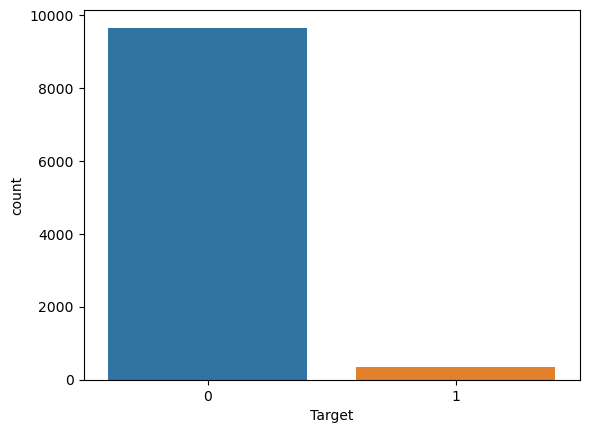

In [10]:
sns.countplot(x='Target', data=df)
plt.show()

In [11]:
# Tentukan fungsi objektif untuk optimisasi Optuna
def knn_objective(trial):
    # Tentukan ruang pencarian hiperparameter
    n_neighbors = trial.suggest_int('n_neighbors', 1, 10)
    
    # Latih klasifikasi K-nearest neighbors
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_classifier.fit(X_train_resampled, y_train_resampled)
    
    # Lakukan prediksi pada data pengujian
    y_pred = knn_classifier.predict(X_test)
    
    # Hitung akurasi
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

In [12]:
def rf_objective(trial):
    # Tentukan ruang pencarian hiperparameter
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    
    # Latih klasifikasi Random Forest
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    rf_classifier.fit(X_train_resampled, y_train_resampled)
    
    # Lakukan prediksi pada data pengujian
    y_pred = rf_classifier.predict(X_test)
    
    # Hitung akurasi
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

In [13]:
def svm_objective(trial):
    # Tentukan ruang pencarian hiperparameter
    C = trial.suggest_loguniform('C', 0.1, 10)
    gamma = trial.suggest_loguniform('gamma', 0.01, 1)
    
    # Latih klasifikasi SVM
    svm_classifier = SVC(C=C, gamma=gamma)
    svm_classifier.fit(X_train_resampled, y_train_resampled)
    
    # Lakukan prediksi pada data pengujian
    y_pred = svm_classifier.predict(X_test)
    
    # Hitung akurasi
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

In [14]:
# Lakukan pencarian hiperparameter dengan Optuna untuk setiap metode

# K-nearest neighbors
knn_study = optuna.create_study(direction='maximize')
knn_study.optimize(knn_objective, n_trials=50)
knn_best_params = knn_study.best_params

# Latih klasifikasi K-nearest neighbors dengan parameter terbaik
knn_classifier = KNeighborsClassifier(**knn_best_params)
knn_classifier.fit(X_train_resampled, y_train_resampled)
knn_y_pred = knn_classifier.predict(X_test)
knn_y_pred_proba = knn_classifier.predict_proba(X_test)[:, 1]  # Probabilitas untuk kelas positif


[I 2023-07-14 14:40:46,028] A new study created in memory with name: no-name-efa5fcf6-08e4-485e-91b4-8b13791cfea7
[I 2023-07-14 14:40:46,273] Trial 0 finished with value: 0.945 and parameters: {'n_neighbors': 1}. Best is trial 0 with value: 0.945.
[I 2023-07-14 14:40:46,633] Trial 1 finished with value: 0.90925 and parameters: {'n_neighbors': 9}. Best is trial 0 with value: 0.945.
[I 2023-07-14 14:40:46,883] Trial 2 finished with value: 0.928 and parameters: {'n_neighbors': 6}. Best is trial 0 with value: 0.945.
[I 2023-07-14 14:40:47,153] Trial 3 finished with value: 0.90925 and parameters: {'n_neighbors': 9}. Best is trial 0 with value: 0.945.
[I 2023-07-14 14:40:47,483] Trial 4 finished with value: 0.9115 and parameters: {'n_neighbors': 10}. Best is trial 0 with value: 0.945.
[I 2023-07-14 14:40:47,878] Trial 5 finished with value: 0.92975 and parameters: {'n_neighbors': 3}. Best is trial 0 with value: 0.945.
[I 2023-07-14 14:40:48,228] Trial 6 finished with value: 0.9115 and parame

In [15]:
# Random Forest
rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=50)
rf_best_params = rf_study.best_params

# Latih klasifikasi Random Forest dengan parameter terbaik
rf_classifier = RandomForestClassifier(**rf_best_params)
rf_classifier.fit(X_train_resampled, y_train_resampled)
rf_y_pred = rf_classifier.predict(X_test)
rf_y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]  # Probabilitas untuk kelas positif


[I 2023-07-14 14:41:01,913] A new study created in memory with name: no-name-798d77fd-08d0-4d52-a8ed-f2ae88a1edd0
[I 2023-07-14 14:41:04,202] Trial 0 finished with value: 0.92125 and parameters: {'n_estimators': 103, 'max_depth': 6}. Best is trial 0 with value: 0.92125.
[I 2023-07-14 14:41:07,053] Trial 1 finished with value: 0.94275 and parameters: {'n_estimators': 99, 'max_depth': 9}. Best is trial 1 with value: 0.94275.
[I 2023-07-14 14:41:10,488] Trial 2 finished with value: 0.92275 and parameters: {'n_estimators': 148, 'max_depth': 6}. Best is trial 1 with value: 0.94275.
[I 2023-07-14 14:41:18,553] Trial 3 finished with value: 0.936 and parameters: {'n_estimators': 166, 'max_depth': 8}. Best is trial 1 with value: 0.94275.
[I 2023-07-14 14:41:24,648] Trial 4 finished with value: 0.9285 and parameters: {'n_estimators': 121, 'max_depth': 7}. Best is trial 1 with value: 0.94275.
[I 2023-07-14 14:41:26,598] Trial 5 finished with value: 0.94025 and parameters: {'n_estimators': 75, 'ma

In [16]:
# Support Vector Machine (SVM)
svm_study = optuna.create_study(direction='maximize')
svm_study.optimize(svm_objective, n_trials=50)
svm_best_params = svm_study.best_params

# Latih klasifikasi SVM dengan parameter terbaik
svm_classifier = SVC(**svm_best_params)
svm_classifier.fit(X_train_resampled, y_train_resampled)
svm_y_pred = svm_classifier.predict(X_test)
svm_y_pred_proba = svm_classifier.decision_function(X_test)  # Score untuk kelas positif


[I 2023-07-14 14:44:27,563] A new study created in memory with name: no-name-49c42291-1c61-4145-a4fd-5ba4e13b08fb
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\3644990138.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 10)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\3644990138.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 0.01, 1)
[I 2023-07-14 14:44:31,553] Trial 0 finished with value: 0.912 and parameters: {'C': 0.21216154270230678, 'gamma': 0.866944529473559}. Best is trial 0 with value: 0.912.
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\3644990138.py:3: FutureWarning: s

C:\Users\HP\AppData\Local\Temp\ipykernel_11176\3644990138.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 10)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\3644990138.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 0.01, 1)
[I 2023-07-14 14:45:21,702] Trial 10 finished with value: 0.9175 and parameters: {'C': 1.765697481387245, 'gamma': 0.35174913252495665}. Best is trial 4 with value: 0.93025.
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\3644990138.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.co

[I 2023-07-14 14:45:45,712] Trial 20 finished with value: 0.926 and parameters: {'C': 5.794385993081317, 'gamma': 0.33838764854296116}. Best is trial 18 with value: 0.94375.
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\3644990138.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 10)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\3644990138.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 0.01, 1)
[I 2023-07-14 14:45:47,462] Trial 21 finished with value: 0.94225 and parameters: {'C': 9.148537019483634, 'gamma': 0.5955435285427473}. Best is trial 18 with value: 0.94375.
C:\Users\HP\App

C:\Users\HP\AppData\Local\Temp\ipykernel_11176\3644990138.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 10)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\3644990138.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 0.01, 1)
[I 2023-07-14 14:46:05,468] Trial 31 finished with value: 0.945 and parameters: {'C': 9.919523494826844, 'gamma': 0.7415764556571416}. Best is trial 23 with value: 0.946.
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\3644990138.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/o

[I 2023-07-14 14:46:22,943] Trial 41 finished with value: 0.94425 and parameters: {'C': 7.549944269117852, 'gamma': 0.7254869392310704}. Best is trial 23 with value: 0.946.
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\3644990138.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 10)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\3644990138.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 0.01, 1)
[I 2023-07-14 14:46:24,562] Trial 42 finished with value: 0.9445 and parameters: {'C': 8.927615752866261, 'gamma': 0.8004224222840515}. Best is trial 23 with value: 0.946.
C:\Users\HP\AppData

In [17]:
# Evaluasi performa klasifikasi

# K-nearest neighbors
knn_result = confusion_matrix(y_test, knn_y_pred)
print("Confusion Matrix K-nearest neighbors:")
print(knn_result)

knn_result1 = classification_report(y_test, knn_y_pred)
print("Classification Report K-nearest neighbors:")
print(knn_result1)

knn_result2 = accuracy_score(y_test, knn_y_pred)
print("Akurasi K-nearest neighbors:", knn_result2)

Confusion Matrix K-nearest neighbors:
[[3709  165]
 [  40   86]]
Classification Report K-nearest neighbors:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3874
           1       0.34      0.68      0.46       126

    accuracy                           0.95      4000
   macro avg       0.67      0.82      0.71      4000
weighted avg       0.97      0.95      0.96      4000

Akurasi K-nearest neighbors: 0.94875


In [18]:
# Random Forest
rf_result = confusion_matrix(y_test, rf_y_pred)
print("Confusion Matrix Random Forest:")
print(rf_result)

rf_result1 = classification_report(y_test, rf_y_pred)
print("Classification Report Random Forest:")
print(rf_result1)

rf_result2 = accuracy_score(y_test, rf_y_pred)
print("Akurasi Random Forest:", rf_result2)


Confusion Matrix Random Forest:
[[3670  204]
 [  14  112]]
Classification Report Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      3874
           1       0.35      0.89      0.51       126

    accuracy                           0.95      4000
   macro avg       0.68      0.92      0.74      4000
weighted avg       0.98      0.95      0.96      4000

Akurasi Random Forest: 0.9455


In [19]:
# Support Vector Machine (SVM)
svm_result = confusion_matrix(y_test, svm_y_pred)
print("Confusion Matrix SVM:")
print(svm_result)

svm_result1 = classification_report(y_test, svm_y_pred)
print("Classification Report SVM:")
print(svm_result1)

svm_result2 = accuracy_score(y_test, svm_y_pred)
print("Akurasi SVM:", svm_result2)


Confusion Matrix SVM:
[[3684  190]
 [  25  101]]
Classification Report SVM:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3874
           1       0.35      0.80      0.48       126

    accuracy                           0.95      4000
   macro avg       0.67      0.88      0.73      4000
weighted avg       0.97      0.95      0.96      4000

Akurasi SVM: 0.94625


In [20]:
# Plot ROC Curve

# K-nearest neighbors
knn_y_pred_proba = knn_classifier.predict_proba(X_test)[:, 1]
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_y_pred_proba)
knn_auc = roc_auc_score(y_test, knn_y_pred_proba)

In [21]:
# Random Forest
rf_y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_pred_proba)
rf_auc = roc_auc_score(y_test, rf_y_pred_proba)

In [22]:
# Support Vector Machine (SVM)
svm_y_pred_proba = svm_classifier.decision_function(X_test)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_y_pred_proba)
svm_auc = roc_auc_score(y_test, svm_y_pred_proba)


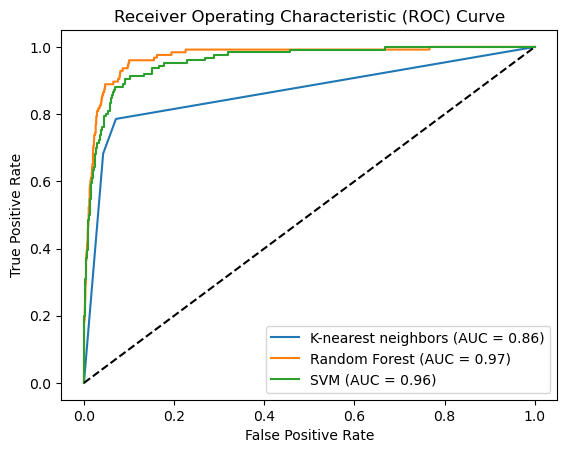

In [23]:
# Plot ROC curves
plt.plot(knn_fpr, knn_tpr, label=f'K-nearest neighbors (AUC = {knn_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.2f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Show the plot
plt.show()

In [25]:
# Optuna Hyperparameter Optimization for XGBoost
def xgb_objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    subsample = trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.6, 0.9, 0.1)
    
    xgb_classifier = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, subsample=subsample, colsample_bytree=colsample_bytree)
    xgb_classifier.fit(X_train_resampled, y_train_resampled)
    
    y_pred = xgb_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

In [26]:
# XGBoost - Optuna Hyperparameter Optimization
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(xgb_objective, n_trials=50)
xgb_best_params = xgb_study.best_params

# Latih klasifikasi XGBoost dengan parameter terbaik
xgb_classifier = XGBClassifier(**xgb_best_params, reg_alpha=0.1, reg_lambda=0.1)
xgb_classifier.fit(X_train_resampled, y_train_resampled)

[I 2023-07-14 14:47:33,947] A new study created in memory with name: no-name-1594be48-693b-4d10-bcf1-415f84e062aa
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:5: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  subsample = trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:6: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com

[I 2023-07-14 14:47:43,033] Trial 6 finished with value: 0.931 and parameters: {'learning_rate': 0.014745712012779928, 'max_depth': 6, 'subsample': 0.7, 'colsample_bytree': 0.6}. Best is trial 3 with value: 0.9485.
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:5: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  subsample = trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:6: FutureWarning: suggest_discrete_

[I 2023-07-14 14:47:54,430] Trial 13 finished with value: 0.955 and parameters: {'learning_rate': 0.08143670525355468, 'max_depth': 8, 'subsample': 0.7, 'colsample_bytree': 0.8}. Best is trial 13 with value: 0.955.
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:5: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  subsample = trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:6: FutureWarning: suggest_discrete_

[I 2023-07-14 14:48:04,964] Trial 20 finished with value: 0.95175 and parameters: {'learning_rate': 0.0657174678433453, 'max_depth': 7, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial 17 with value: 0.9575.
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:5: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  subsample = trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:6: FutureWarning: suggest_discret

[I 2023-07-14 14:48:16,367] Trial 27 finished with value: 0.95075 and parameters: {'learning_rate': 0.06769837792275459, 'max_depth': 7, 'subsample': 0.6, 'colsample_bytree': 0.9}. Best is trial 17 with value: 0.9575.
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:5: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  subsample = trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:6: FutureWarning: suggest_discre

[I 2023-07-14 14:48:27,679] Trial 34 finished with value: 0.906 and parameters: {'learning_rate': 0.048055014867225576, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 17 with value: 0.9575.
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:5: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  subsample = trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:6: FutureWarning: suggest_discret

[I 2023-07-14 14:48:38,987] Trial 41 finished with value: 0.956 and parameters: {'learning_rate': 0.0854074019241889, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 17 with value: 0.9575.
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:5: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  subsample = trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:6: FutureWarning: suggest_discrete_

[I 2023-07-14 14:48:52,383] Trial 48 finished with value: 0.957 and parameters: {'learning_rate': 0.08323045088055953, 'max_depth': 10, 'subsample': 0.9, 'colsample_bytree': 0.6}. Best is trial 17 with value: 0.9575.
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:5: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  subsample = trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1)
C:\Users\HP\AppData\Local\Temp\ipykernel_11176\2919611894.py:6: FutureWarning: suggest_discret

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09980534488307351,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [27]:
# Evaluasi hasil klasifikasi XGBoost
xgb_y_pred = xgb_classifier.predict(X_test)
xgb_result = confusion_matrix(y_test, xgb_y_pred)
print("Confusion Matrix XGBoost:")
print(xgb_result)

xgb_result1 = classification_report(y_test, xgb_y_pred)
print("Classification Report XGBoost:")
print(xgb_result1)

xgb_result2 = accuracy_score(y_test, xgb_y_pred)
print("Akurasi XGBoost:", xgb_result2)

Confusion Matrix XGBoost:
[[3723  151]
 [  16  110]]
Classification Report XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3874
           1       0.42      0.87      0.57       126

    accuracy                           0.96      4000
   macro avg       0.71      0.92      0.77      4000
weighted avg       0.98      0.96      0.97      4000

Akurasi XGBoost: 0.95825


In [28]:
# Definisikan model-model yang akan digunakan dalam ensemble
models = [('Random Forest', rf_classifier), ('XGBoost', xgb_classifier)]

# Buat Voting Classifier
voting_classifier = VotingClassifier(models, voting='soft')
voting_classifier.fit(X_train_resampled, y_train_resampled)

# Evaluasi hasil klasifikasi Voting Classifier
voting_y_pred = voting_classifier.predict(X_test)
voting_result = confusion_matrix(y_test, voting_y_pred)
print("Confusion Matrix Voting Classifier:")
print(voting_result)

voting_result1 = classification_report(y_test, voting_y_pred)
print("Classification Report Voting Classifier:")
print(voting_result1)

voting_result2 = accuracy_score(y_test, voting_y_pred)
print("Akurasi Voting Classifier:", voting_result2)

Confusion Matrix Voting Classifier:
[[3713  161]
 [  15  111]]
Classification Report Voting Classifier:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3874
           1       0.41      0.88      0.56       126

    accuracy                           0.96      4000
   macro avg       0.70      0.92      0.77      4000
weighted avg       0.98      0.96      0.96      4000

Akurasi Voting Classifier: 0.956


In [29]:
# Definisikan Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5)

# Lakukan evaluasi menggunakan Stratified K-Fold Cross Validation
scores = []
for train_index, val_index in skf.split(X_train_resampled, y_train_resampled):
    X_train_fold, X_val_fold = X_train_resampled[train_index], X_train_resampled[val_index]
    y_train_fold, y_val_fold = y_train_resampled[train_index], y_train_resampled[val_index]

    model = XGBClassifier(**xgb_best_params)
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    accuracy = accuracy_score(y_val_fold, y_pred)
    scores.append(accuracy)

mean_accuracy = np.mean(scores)
print("Mean Accuracy (Stratified K-Fold):", mean_accuracy)

Mean Accuracy (Stratified K-Fold): 0.9853896015419826
